In [ ]:
import numpy as np
import cvxopt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Data Preprocessing and Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to range [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Splitting Data into Training and Validation (using 90% for training)
train_len = int(0.9 * len(train_dataset))  # 90% for training
val_len = len(train_dataset) - train_len   # 10% for validation
train_data, val_data = random_split(train_dataset, [train_len, val_len])

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)  # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No shuffle for testing


def prepare_data(loader):
    """ Prepare data for SVM training. """
    X, y = [], []
    for images, labels in loader:
        X.append(images.view(images.size(0), -1).numpy())  # Flatten images
        y.append(labels.numpy())
    return np.vstack(X), np.concatenate(y)

# Prepare data using the largest percentage (90% for training)
X_train, y_train = prepare_data(train_loader)  # Prepare the 90% training data
X_test, y_test = prepare_data(test_loader)    # Prepare the entire test data
y_train = np.where(y_train == 0, -1, 1)  # Convert 0 -> -1, others -> 1
y_test = np.where(y_test == 0, -1, 1)    # Convert 0 -> -1, others -> 1


# Prepare training data
X_train, y_train = prepare_data(train_loader)

# Use only a subset of the training data to avoid memory issues
subset_size = 5000  # Adjust this size based on your memory capacity
X_train = X_train[:subset_size]
y_train = y_train[:subset_size]
# Use only a subset of the training data to avoid memory issues


# Convert labels to {1, -1} for SVM
y_train = np.where(y_train == 0, -1, 1)  # Example: Convert '0' to '-1' and others to '1'

def solve_dual_problem(X, y, C=1.0):
    """
    Solves the SVM dual problem using Quadratic Programming.
    """
    n_samples, n_features = X.shape

    # Kernel matrix for linear kernel
    K = np.dot(X, X.T)  # Linear kernel: K(x_i, x_j) = x_i · x_j

    # Set up the quadratic programming problem
    P = cvxopt.matrix(np.outer(y, y) * K)  # Ensure P is a matrix of size (n_samples, n_samples)
    q = cvxopt.matrix(-np.ones(n_samples))
    G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = cvxopt.matrix(y, (1, n_samples), 'd')
    b = cvxopt.matrix(0.0)

    # Solve the quadratic programming problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    return alphas

# Calculate alphas
alphas = solve_dual_problem(X_train, y_train, C=1.0)



In [ ]:
# Print the result (Lagrange multipliers)
print("Lagrange multipliers (alphas):", alphas)


def compute_metrics(y_true, y_pred):
  TP = TN = FP = FN = 0;
  for true, pred in zip(y_true, y_pred):
    if true == 1 and pred == 1:
      TP += 1
    elif true == -1 and pred == -1:
      TN += 1
    elif true == -1 and pred == 1:
      FP += 1
    elif true == 1 and pred == -1:
      FN += 1

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP) if (TP + FP) > 0 else 0
  recall = TP / (TP + FN) if (TP + FN) > 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  return {
      "Accuracy": accuracy,
      "Precision": precision,
      "Recall": recall,
      "F1 Score": f1_score
  }

  # metrics = compute_metrics(y_test, y_pred)
  # for metric, value in metrics.items():
  #   print(f"{metric}: {value}")





Lagrange multipliers (alphas): [8.57648799e-12 9.03959552e-02 1.76520292e-11 ... 9.14612564e-02
 1.73068282e-11 5.57517651e-11]


In [ ]:
def calculate_w_b(X, y, alphas):

    #Calculate the weight vector w and bias b for the SVM classifier.
    # Compute w: sum(alpha_i * y_i * x_i)
    w = np.sum((alphas * y)[:, None] * X, axis=0)

    # Find support vectors: where 0 < alpha_i < C
    support_vector_indices = np.where((alphas > 1e-4) & (alphas < 1.0))[0]
    # Compute b using a support vector
    b = y[support_vector_indices[0]] - np.dot(w, X[support_vector_indices[0]])

    return w, b

# Calculate w and b
w, b = calculate_w_b(X_train, y_train, alphas)

# SVM Prediction Function
def svm_predict(X, w, b):
    """
    Predict the class label for the given data using the SVM classifier.
    """
    return np.sign(np.dot(X, w) + b)

# Test the classifier
X_test, y_test = prepare_data(test_loader)
y_test = np.where(y_test == 0, -1, 1)  # Same label conversion as training
y_pred = svm_predict(X_test, w, b)

y_train_pred = svm_predict(X_train, w, b)
training_accuracy = np.mean(y_train_pred == y_train)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

metrics = compute_metrics(y_test, y_pred)
for metric, value in metrics.items():
  print(f"{metric}: {value}")

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy on test set:", accuracy)


Training Accuracy: 100.00%
Accuracy: 0.9847
Precision: 0.9935433596793944
Recall: 0.9894678492239468
F1 Score: 0.991501416430595
Accuracy on test set: 0.9847


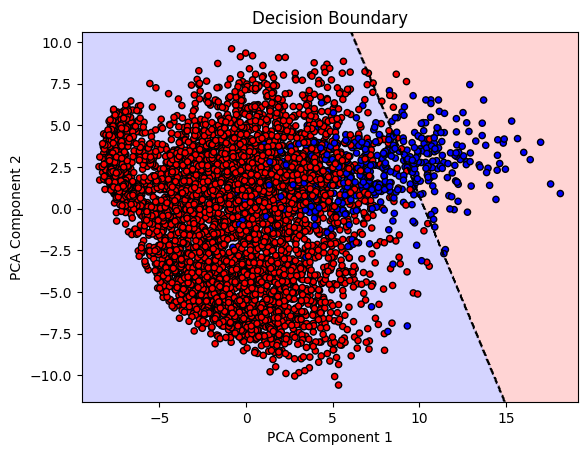

In [ ]:
def plot_decision_boundaries(X, y, w, b):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),    np.linspace(y_min, y_max, 500))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_original = pca.inverse_transform(grid_points)
    Z = svm_predict(grid_points_original, w, b)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, colors=['#FFAAAA', '#AAAAFF', '#AAFFAA'])
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1.5, linestyles='--')

    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='bwr', edgecolor='k', s=20)
    plt.title('Decision Boundary')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


plot_decision_boundaries(X_train, y_train, w, b)




In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
rf_train_pred = best_rf.predict(X_train)
rf_train_accuracy = np.mean(rf_train_pred == y_train)
print("Training Accuracy for Random Forest:", rf_train_accuracy)

rf_pred = rf_grid.predict(X_test)
rf_metrics = compute_metrics(y_test, rf_pred)
print("Random Forest Evaluation Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")


Training Accuracy for Random Forest: 0.9996
Random Forest Evaluation Metrics:
Accuracy: 0.9914
Precision: 0.9923
Recall: 0.9982
F1 Score: 0.9952


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Define parameter grid for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM model
svm_model = SVC()

# Perform grid search for SVM
svm_grid = GridSearchCV(svm_model, svm_params, cv=3)
svm_grid.fit(X_train, y_train)

# Evaluate SVM on the test set
y_pred_svm = svm_grid.predict(X_test)
svm_metrics = compute_metrics(y_test, y_pred_svm)

# Calculate Training Accuracy
best_svm = svm_grid.best_estimator_
svm_train_pred = best_svm.predict(X_train)
svm_train_accuracy = np.mean(svm_train_pred == y_train)
print("Training Accuracy for SVM:", svm_train_accuracy)

# Print SVM metrics
print("SVM Evaluation Metrics:")
for metric, value in svm_metrics.items():
    print(f"{metric}: {value:.4f}")


Training Accuracy for SVM: 1.0
SVM Evaluation Metrics:
Accuracy: 0.9961
Precision: 0.9973
Recall: 0.9983
F1 Score: 0.9978


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grid for KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize KNN model
knn_model = KNeighborsClassifier()

# Perform grid search for KNN
knn_grid = GridSearchCV(knn_model, knn_params, cv=3)
knn_grid.fit(X_train, y_train)

# Evaluate KNN on the test set
y_pred_knn = knn_grid.predict(X_test)
knn_metrics = compute_metrics(y_test, y_pred_knn)

# Calculate Training Accuracy
best_knn = knn_grid.best_estimator_
knn_train_pred = best_knn.predict(X_train)
knn_train_accuracy = np.mean(knn_train_pred == y_train)
print("Training Accuracy for KNN:", knn_train_accuracy)

# Print KNN metrics
print("KNN Evaluation Metrics:")
for metric, value in knn_metrics.items():
    print(f"{metric}: {value:.4f}")

Training Accuracy for KNN: 0.9974
KNN Evaluation Metrics:
Accuracy: 0.9935
Precision: 0.9980
Recall: 0.9948
F1 Score: 0.9964
